# 01_track.ipynb
### Use Ocetrac to define track MHW objects 

This notebook provides an example of how one might preprocess gridded sea surface temperature (SST) data to extract anomalies and detect extreme values. Here we will use monthly mean SST from the [NOAA Optimum Interpolation Sea Surface Temperature](https://www.ncdc.noaa.gov/oisst/data-access) (OISST v2.1) dataset. This data is measured from a blend of satellite and in-situ observations. We elect to use data from AVHRR-only satellites. This product is available from September 1981 through present on a 1/4º global regular grid.

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import ocetrac
print('Using OCETRAC version', ocetrac.__version__)

Using OCETRAC version 0.0.10


### 1. Import preprocessed data

In [ ]:
# file_path = '/glade/scratch/scanh/MHW_pre/preprocess_mhw_OISST_monthly_noTrend_stn_quarterdegree_global.nc'
file_path = '/glade/scratch/scanh/MHW_pre/preprocess_mhw_OISSTv2_monthly_notrend_stn.nc'
ds = xr.open_dataset(file_path, decode_times=True)

# Adjust mask so that data poleward of 65ºN and 70ºS is ignored
mask = ds.mask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 


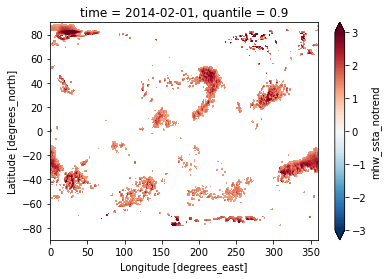

In [ ]:
# plot of SSTA that exceeds a predefined threshold (e.g. 90th percentile)
ds.mhw_ssta_notrend.sel(time=('2014-2-01')).plot(vmin=-3, vmax=3, cmap='RdBu_r', extend='both');

In [ ]:
%%time
labels, N = ocetrac.track(ds.mhw_ssta_notrend, mask, radius=10, area_quantile=0.75)

min area (km2) 	 2010.0
inital features identified 	 2928
final features tracked 	 2928
CPU times: user 6min 50s, sys: 59.1 s, total: 7min 49s
Wall time: 7min 50s


In [ ]:
labels = labels.where(labels!=0, drop=False, other=np.nan)


**The basic output of `ocetrac.track` provides:**
- the minimum object area used to filter out MHWs that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MHW objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MHW objects tracked in space and time. 

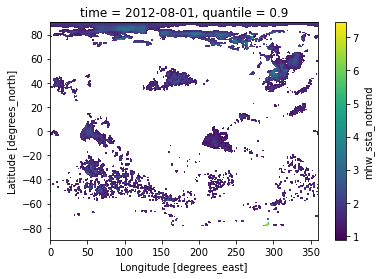

In [ ]:
ds.mhw_ssta_notrend.sel(time=('2012-08-01')).plot();

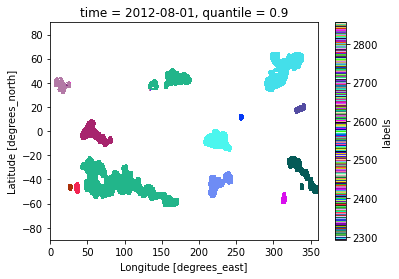

In [ ]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(labels.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


# Make a quick plot of the labeled MHWs identified with Ocetrac
labels.sel(time=('2012-08-01')).plot(cmap= cm)

### Save tracked labels

In [ ]:
# Specify path to save output 
out_path = '/glade/scratch/scanh/ocetrac_data/'

ds_out = labels.to_dataset(name='ocetrac_labels')
ds_out.attrs['threshold'] = 0.9

# Save Dataset to netCDF
ds_out.to_netcdf(out_path+'ocetrac_labels_montly_OISST_noTrend_stn_quarterdegree_global.nc', mode='w')
